# Final Project Combined Preliminary EDA

In [152]:
# import libraries
import numpy as np
from numpy import errstate,isneginf
import pandas as pd
from time import time
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import re as re
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set(style = 'white')

%matplotlib inline

## Install Reverse Geocoder
This helps us get county and city data against longtitude and latitude zillow data. Source: https://github.com/thampiman/reverse-geocoder

In [153]:
# only need to install reverse_geocoder if never installed before
# !pip install reverse_geocoder
import reverse_geocoder as rg

## Read in Data

In [154]:
# load the data 
train_2016 = pd.read_csv("train_2016_v2.csv")
properties_2016 = pd.read_csv("properties_2016.csv")

# Ray reading in data from a different file location - comment this out if you need to change it please
#train_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/train_2016_v2.csv")
#properties_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/properties_2016.csv")

C:\Users\amybr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory Data Analysis

In [155]:
# look at properties 2016 dataframe
properties_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
storytypeid,1624,NaN,NaN,NaN,7,0,7,7,7,7,7
basementsqft,1628,NaN,NaN,NaN,646.883,538.793,20,272,534,847.25,8516
yardbuildingsqft26,2647,NaN,NaN,NaN,278.297,369.732,10,96,168,320,6141
fireplaceflag,5163,1,True,5163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,6061,NaN,NaN,NaN,7.20261,2.43629,2,7,7,7,27
typeconstructiontypeid,6747,NaN,NaN,NaN,5.99956,0.38405,4,6,6,6,13
finishedsquarefeet13,7672,NaN,NaN,NaN,1178.9,357.073,120,960,1296,1440,2688
buildingclasstypeid,12629,NaN,NaN,NaN,3.72595,0.5017,1,3,4,4,5
decktypeid,17096,NaN,NaN,NaN,66,0,66,66,66,66,66
finishedsquarefeet6,22001,NaN,NaN,NaN,2414.34,7695.3,117,1079,1992,3366,952576


In [156]:
# look at train 2016 dataframe
train_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
parcelid,90275,NaN,NaN,NaN,1.29847e+07,2.50451e+06,1.07117e+07,1.15595e+07,1.25473e+07,1.42276e+07,1.62961e+08
logerror,90275,NaN,NaN,NaN,0.0114572,0.161079,-4.605,-0.0253,0.006,0.0392,4.737
transactiondate,90275,352,2016-07-29,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
# Convert the transactiondate column to a datetime
train_2016.transactiondate = pd.to_datetime(train_2016.transactiondate, infer_datetime_format=True)
print(train_2016.dtypes)

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
dtype: object


## Merge train + properties data

In [158]:
# merge the logerror and transactiondate the properties and filter to only 2016 data
combined_df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
combined_df.set_index(keys='parcelid',inplace=True)

In [159]:
# convert Lat/Long to actual Lat/Long
# note - run this cell one-time or latitude/longtitude will continue to divide by 1e6
combined_df['latitude'] = combined_df['latitude']/1e6
combined_df['longitude'] = combined_df['longitude']/1e6

# combine latitude and longtitude into one column
combined_df['latlng'] = combined_df['latitude'].map(str) + ',' + combined_df['longitude'].map(str)

## Map Latitude + Longitude to City & County

In [160]:
# lookup lat/long locations
coordinates = combined_df["latlng"].apply(lambda x: tuple(x.split(',')))
results = rg.search(coordinates.tolist())

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

combined_df['city'] = city
combined_df['county'] = county

# create a combined variable for better categorization
combined_df['county_city'] = list(zip(county, city))
combined_df['county_city'] = combined_df['county_city'].astype('category')

In [161]:
# verify that city, county, and county_city are pulled in correctly
combined_df.head(2)

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,latlng,city,county,county_city
parcelid,,,,,,,,,,,,,,,,,,,,,
10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0276,2016-01-01,"34.144442,-118.654084",Hidden Hills,Los Angeles County,"(Los Angeles County, Hidden Hills)"
10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.1684,2016-01-01,"34.14043,-118.625364",Calabasas,Los Angeles County,"(Los Angeles County, Calabasas)"


# Only keep counties in Los Angeles, Orange and Ventura, California. 
### (Per Zillow you are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.)

In [162]:
print(combined_df['county'].value_counts())

Los Angeles County       59641
Orange County            22972
Ventura County            7535
San Bernardino County      115
Kern County                  9
Santa Barbara County         3
Name: county, dtype: int64


In [163]:
combined_df = combined_df[(combined_df['county'] == 'Los Angeles County') | (combined_df['county'] == 'Orange County') | (combined_df['county'] == 'Ventura County')]


In [164]:
print(combined_df['county'].value_counts())

Los Angeles County    59641
Orange County         22972
Ventura County         7535
Name: county, dtype: int64


## We end up with 90,148 rows of data

## Now we look at the continuous data with the highest correlations

In [165]:
# create a deep copy of the merged dataframe (combined_df) above
ray_df = combined_df.copy(deep = True)

In [166]:
def cat_or_float(df):
    categorical_col = []
    continuous_col = []
    for i in df.columns:
        if type(df[i].iloc[1]) == str:
            categorical_col.append(i)
        if type(df[i].iloc[1]) == np.float64:
            continuous_col.append(i)
    return continuous_col, categorical_col

In [167]:
cont_col, cat_col = cat_or_float(ray_df)

In [168]:
display(cont_col[:10])
display(cat_col)

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet']

['propertycountylandusecode', 'propertyzoningdesc', 'latlng', 'city', 'county']

In [169]:
# add logerror into the cat_col
for i in cat_col:
    print('categorical column {0} contains {1} unique values for dummy columns'.format(i, len(ray_df[i].unique())))
cat_col.append('logerror')

categorical column propertycountylandusecode contains 109 unique values for dummy columns
categorical column propertyzoningdesc contains 2141 unique values for dummy columns
categorical column latlng contains 84439 unique values for dummy columns
categorical column city contains 217 unique values for dummy columns
categorical column county contains 3 unique values for dummy columns


In [170]:
print(ray_df['city'].head())

parcelid
10754147       Hidden Hills
10759547          Calabasas
10843547     Ladera Heights
10859147       Sherman Oaks
10879947    North Hollywood
Name: city, dtype: object


In [171]:
cat_df = ray_df[['county','logerror']]
con_df = ray_df[cont_col]

In [172]:
# Turns categorical data into dummy binary columns
df_dummies_cat = pd.get_dummies(cat_df)

In [173]:
print(df_dummies_cat.columns)

Index(['logerror', 'county_Los Angeles County', 'county_Orange County',
       'county_Ventura County'],
      dtype='object')


## <font color=green> [Ray] Going to plot corr of continuous variables (53 variables)</font>

In [174]:
print(*con_df.columns, sep=" - ")

airconditioningtypeid - architecturalstyletypeid - basementsqft - bathroomcnt - bedroomcnt - buildingclasstypeid - buildingqualitytypeid - calculatedbathnbr - decktypeid - finishedfloor1squarefeet - calculatedfinishedsquarefeet - finishedsquarefeet12 - finishedsquarefeet13 - finishedsquarefeet15 - finishedsquarefeet50 - finishedsquarefeet6 - fips - fireplacecnt - fullbathcnt - garagecarcnt - garagetotalsqft - heatingorsystemtypeid - latitude - longitude - lotsizesquarefeet - poolcnt - poolsizesum - pooltypeid10 - pooltypeid2 - pooltypeid7 - propertylandusetypeid - rawcensustractandblock - regionidcity - regionidcounty - regionidneighborhood - regionidzip - roomcnt - storytypeid - threequarterbathnbr - typeconstructiontypeid - unitcnt - yardbuildingsqft17 - yardbuildingsqft26 - yearbuilt - numberofstories - structuretaxvaluedollarcnt - taxvaluedollarcnt - assessmentyear - landtaxvaluedollarcnt - taxamount - taxdelinquencyyear - censustractandblock - logerror


In [175]:
def col_append(col_ind):
    col = cont_col[col_ind:col_ind+10]
    col.append('logerror')
    return col

In [176]:
df1, df2, df3, df4, df5 = con_df[col_append(0)], con_df[col_append(10)], con_df[col_append(20)], con_df[col_append(30)], con_df[col_append(40)]
df6 = con_df[con_df.columns[50:]]

## From the chart below, we see a log error has a higher correlation with architecturalstyletypeid and basementsqft 

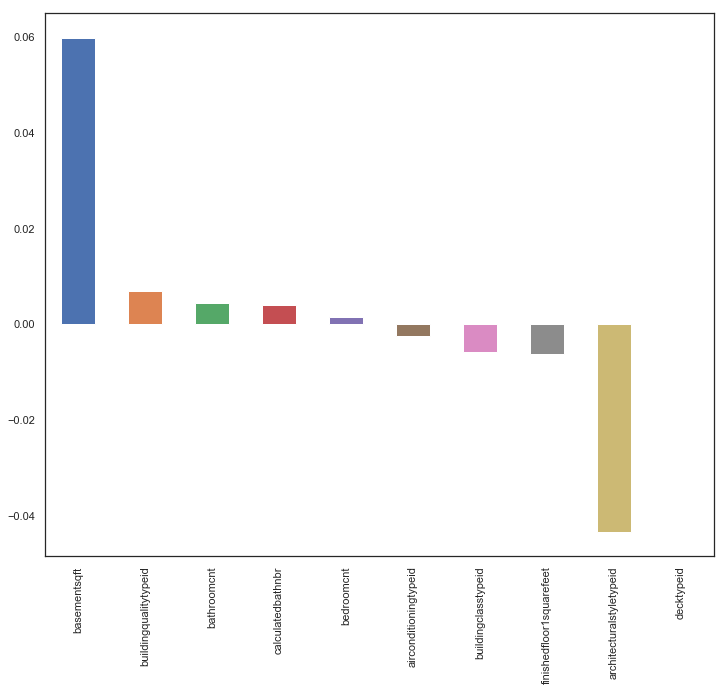

In [177]:
# df1 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df1.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## From plotting the scatter plot we see that 1, the data is only populated for Ventura County and Los Angeles County. 2, there are only 51 examples of data. Log error does not seem to deviate too much.

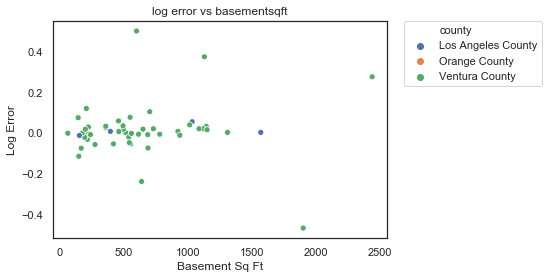

,basementsqft
county,
Los Angeles County,4
Orange County,0
Ventura County,47


In [178]:
xvar = 'basementsqft'
sns.scatterplot(x = 'basementsqft', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs basementsqft')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Basement Sq Ft")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## From the plot below, we see something similar to above, so we can also drop this column.

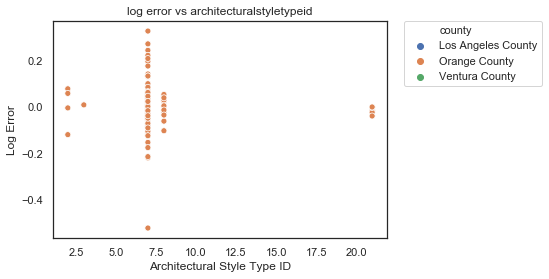

,architecturalstyletypeid
county,
Los Angeles County,1
Orange County,182
Ventura County,0


In [179]:
xvar = 'architecturalstyletypeid'
sns.scatterplot(x = 'architecturalstyletypeid', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs architecturalstyletypeid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Architectural Style Type ID")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

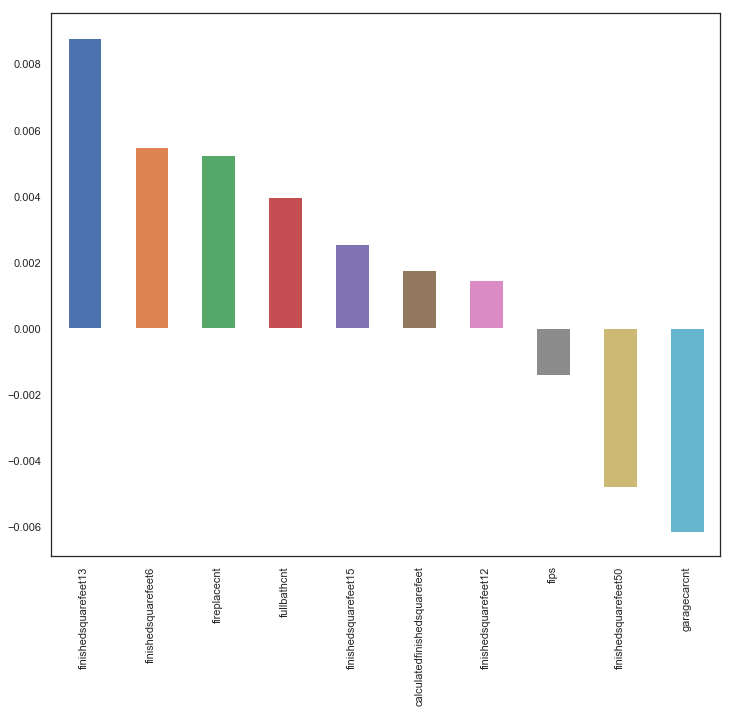

In [180]:
# df2 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df2.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

# Now looking at garage car counts, we see there's quite a bit of log error deviation around the 1-4 car garages, focused on Orange County and Ventura County. This presents an opportunity for an interaction feature multiplying the county categoricals with this garage cat count

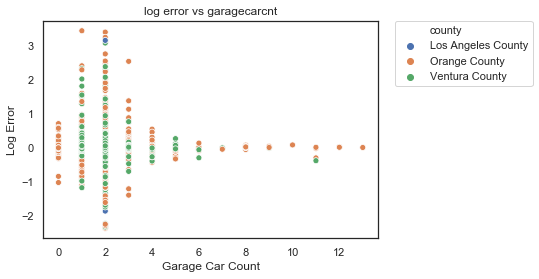

,garagecarcnt
county,
Los Angeles County,208
Orange County,20421
Ventura County,6798


In [181]:
xvar = 'garagecarcnt'
sns.scatterplot(x = 'garagecarcnt', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs garagecarcnt')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Garage Car Count")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

# Same with 1-2 fireplaces. Primarily around OC/VC. Same idea here.

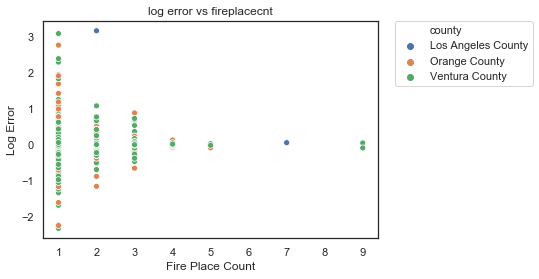

,fireplacecnt
county,
Los Angeles County,83
Orange County,4657
Ventura County,5181


In [182]:
sns.scatterplot(x = 'fireplacecnt', y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs fireplacecnt')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Fire Place Count")
plt.ylabel("Log Error")
plt.show()

display(ray_df.groupby(['county'],axis = 0).count()[['fireplacecnt']])

#  Federal Information Processing Standard code. Every single home has a value. We see counties each have their own unique fips code... maybe some opportunity here. Also, should we remove those LA County with FIPS in 6110 and 6060? Can someone look into this.

## AB - Looked into it. 6110 and 6060 are not valid FIPS codes. FIPS codes are just county IDs and we should be able to drop this column

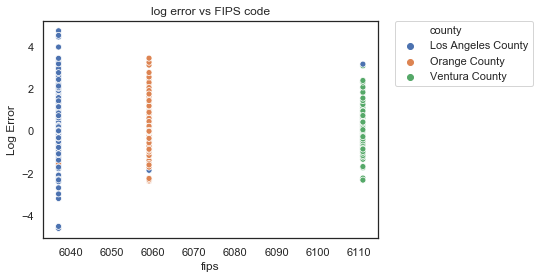

,fips
county,
Los Angeles County,59641
Orange County,22972
Ventura County,7535


In [183]:
xvar = 'fips'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs FIPS code')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

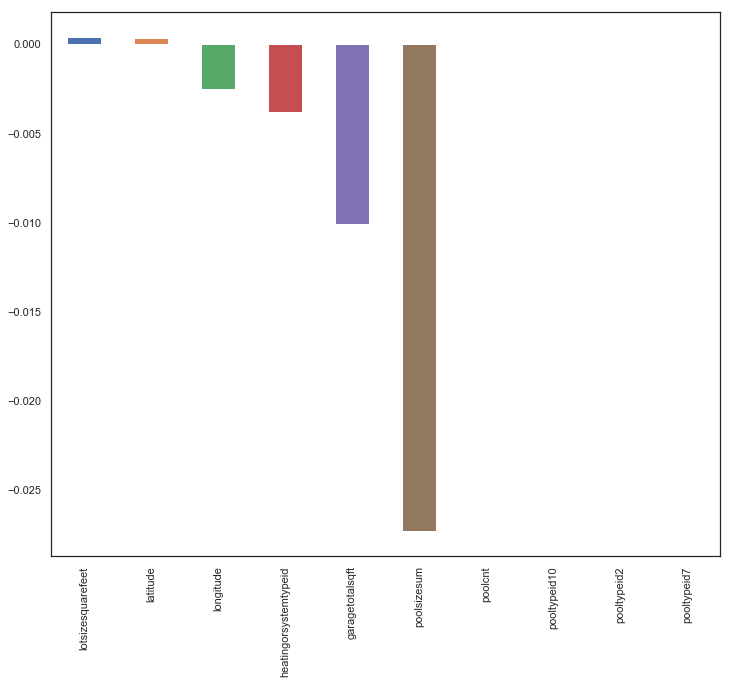

In [184]:
# df3 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df3.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## A lot of spread here, primarily OC/VC.

27427


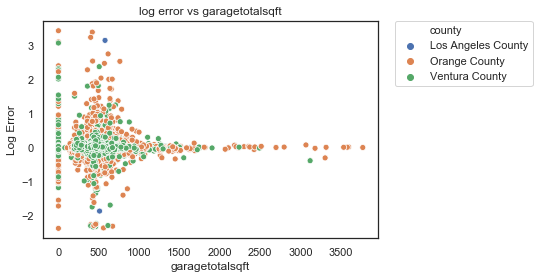

,garagetotalsqft
county,
Los Angeles County,208
Orange County,20421
Ventura County,6798


In [185]:
xvar = 'garagetotalsqft'
print(ray_df[xvar].count())
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs garagetotalsqft')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

# Poolsizesum doesn't contribute that much error, there are some outliers. We should investigate further why there's an outlier but doesn't have many records.

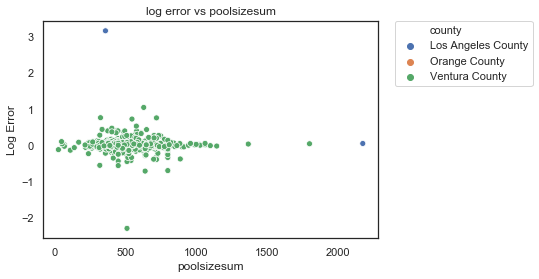

,poolsizesum
county,
Los Angeles County,12
Orange County,0
Ventura County,893


In [186]:
xvar = 'poolsizesum'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs poolsizesum')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## This looks pretty important and a good categorical feature. We should actually figure out how we should treat these, this is more categorical than continuous.

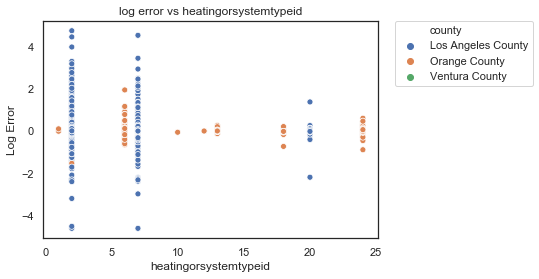

,heatingorsystemtypeid
county,
Los Angeles County,51712
Orange County,2251
Ventura County,49


In [187]:
xvar = 'heatingorsystemtypeid'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs heatingorsystemtypeid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

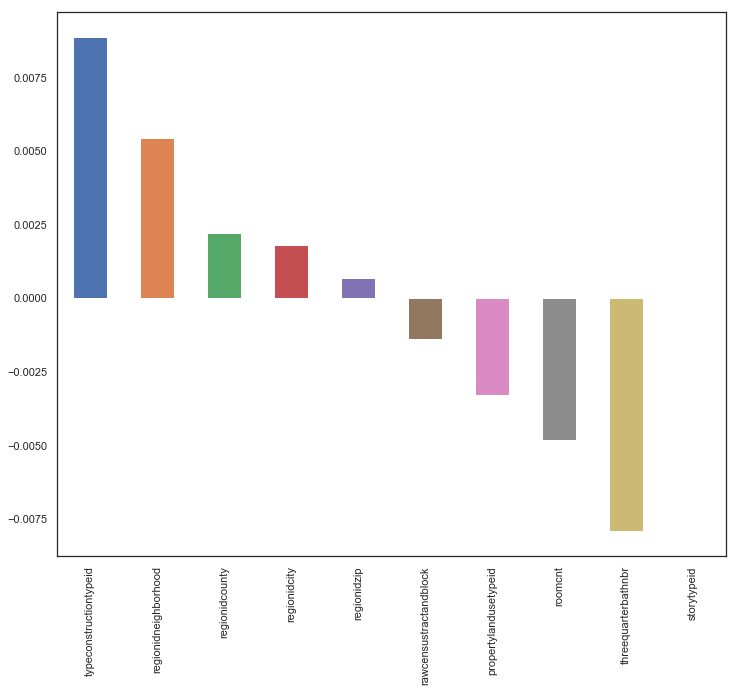

In [188]:
# df4 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df4.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Huge amounts of error for LA with a room count of 0's (Studios)... Outlier of a place with 80+ rooms.... probably a bad data point.

### AB - don't think it's a bad data point - I found at least two homes on Zillow that are 20 bed/25+ bath, so it seems reasonable they might have 80 total rooms

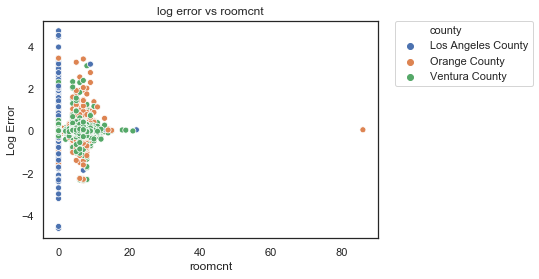

,roomcnt
county,
Los Angeles County,59640
Orange County,22972
Ventura County,7535


In [189]:
xvar = 'roomcnt'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs roomcnt')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

## Not really sure what this means.... probably not important

### AB - 3/4 bath means it has a shower but not a tub. Probably could be added to the full bath count.

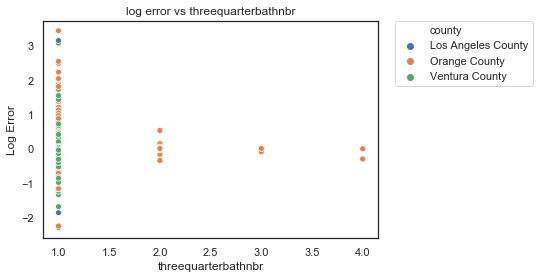

,threequarterbathnbr
county,
Los Angeles County,67
Orange County,7437
Ventura County,2164


In [190]:
xvar = 'threequarterbathnbr'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs threequarterbathnbr')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

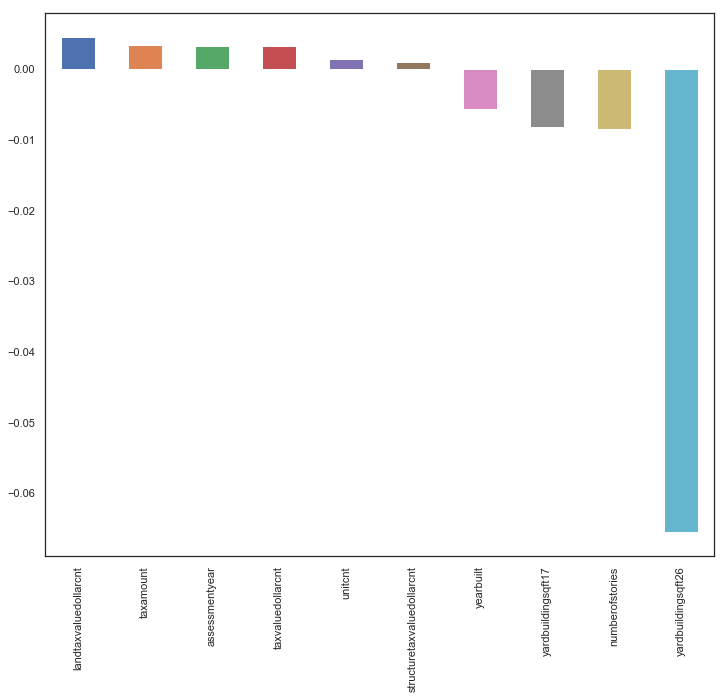

In [191]:
# df5 - get Correlation of logerror with other variables:
plt.figure(figsize=(12,10))
df5.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Remove yardbuildingsqft26

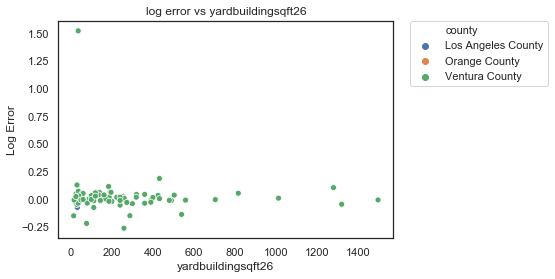

,yardbuildingsqft26
county,
Los Angeles County,1
Orange County,0
Ventura County,81


In [192]:
xvar = 'yardbuildingsqft26'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs yardbuildingsqft26')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

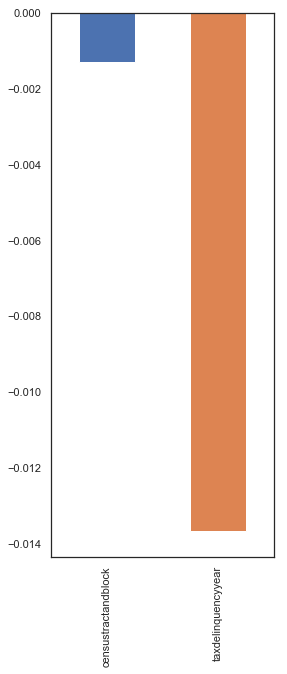

In [193]:
# df6 - get Correlation of logerror with other variables:
plt.figure(figsize=(4,10))
df6.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## More recent the year, more logerror.

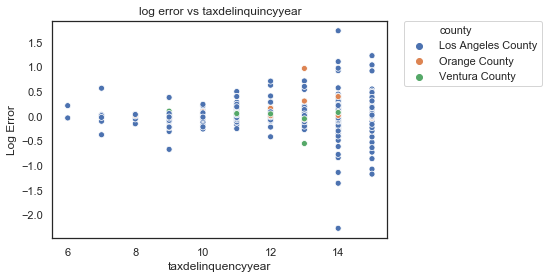

,taxdelinquencyyear
county,
Los Angeles County,1510
Orange County,190
Ventura County,40


In [194]:
xvar = 'taxdelinquencyyear'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs taxdelinquincyyear')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'],axis = 0).count()[[xvar]])

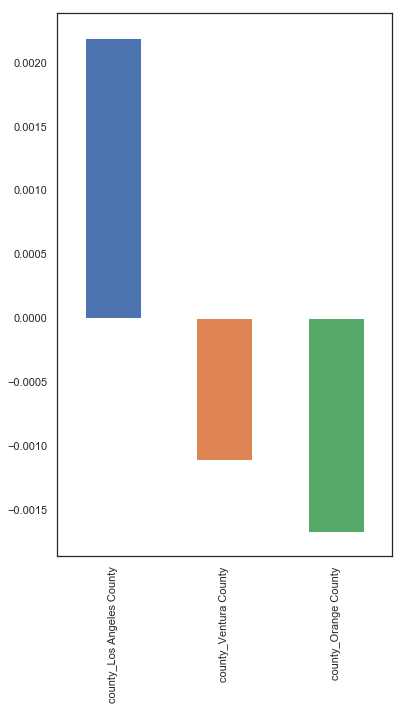

In [195]:
plt.figure(figsize=(6,10))
df_dummies_cat.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')
plt.show()

## Los Angeles has the most log error and records.

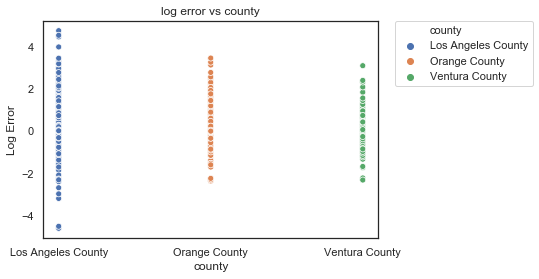

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,latlng,city,county_city
county,,,,,,,,,,,,,,,,,,,,,
Los Angeles County,21352,1,4,59641,59641,440,57143,57714,14,70,...,58776,59381,1510,1510,57887,59641,59641,59641,59641,59641
Orange County,2907,182,0,22972,22972,0,754,21658,0,0,...,22311,22819,190,190,22668,22972,22972,22972,22972,22972
Ventura County,43,0,47,7535,7535,0,49,6926,558,6850,...,7225,7333,40,40,7405,7535,7535,7535,7535,7535


In [196]:
xvar = 'county'
sns.scatterplot(x = xvar, y = 'logerror', hue = 'county', data = ray_df).set_title('log error vs county')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(xvar)
plt.ylabel("Log Error")
plt.show()
#print(ray_df.groupby(['county','garagetotalsqft'],axis = 0).count()[['logerror']])
display(ray_df.groupby(['county'], axis = 0).count())

## <font color=red> Drop columns <font>
<font color=purple>**Ray to edit the code below after data exploration above as we will no longer drop all the following columns** <font>

In [197]:
# drop columns that don't contribute very much to logerror or are duplicative
#      yardbuildinfsqft26 - doesn't have much variation in logerror, per Ray
#      FIPS - described by county
#      storytypeid - only ever set to 7-basement; fully represented by the basementsqft column

combined_df.drop(labels=['storytypeid','yardbuildingsqft26','fips'], axis=1,inplace=True)

In [198]:
#combined_df.dtypes.transpose()

In [199]:
# standardize and convert data to 1 or 0
def convert_yn(x):
    if x in ['True','Y']:
        return 1
    return 0

combined_df['hashottuborspa'] = combined_df['hashottuborspa'].astype('str').map(convert_yn)
combined_df['taxdelinquencyflag'] = combined_df['taxdelinquencyflag'].astype('str').map(convert_yn)
combined_df['fireplaceflag'] = combined_df['fireplaceflag'].astype('str').map(convert_yn)

In [200]:
# interpolate missing values for the following columns
interpolate_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', \
                      'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', \
                      'garagetotalsqft']

# default interpolation method is linear, let's just stick with that
for column in interpolate_columns:
    combined_df[column].interpolate(inplace=True)

In [201]:
# Commenting out for now - will normalize instead of using log transform
# transform columns with very large st dev to log
#log_transform_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', \
#                        'taxamount', 'lotsizesquarefeet']

#eps = 1e-6
#for column in log_transform_columns:
#    combined_df[column] = np.log10(combined_df[column] + eps)


In [202]:
# normalize continuous variables
normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', \
                     'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17', \
                    'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt',
                    'taxamount']

for column in normalize_columns:
    combined_df[column] = (combined_df[column] - combined_df[column].mean()) / combined_df[column].std()

In [203]:
#combined_df.shape
combined_df.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
airconditioningtypeid,24302,NaN,NaN,NaN,NaN,NaN,1.96971,3.2105,1,1,1,1,13
architecturalstyletypeid,183,NaN,NaN,NaN,NaN,NaN,7.39891,2.6477,2,7,7,7,21
basementsqft,51,NaN,NaN,NaN,NaN,NaN,635.922,477.103,63,232,544,853,2443
bathroomcnt,90148,NaN,NaN,NaN,NaN,NaN,2.20344,1.08343,0,2,2,3,20
bedroomcnt,90148,NaN,NaN,NaN,NaN,NaN,3.07741,1.28281,0,2,3,4,16
buildingclasstypeid,440,NaN,NaN,NaN,NaN,NaN,3.77955,0.446745,2,4,4,4,5
buildingqualitytypeid,57946,NaN,NaN,NaN,NaN,NaN,5.78608,1.80805,1,4,7,7,12
calculatedbathnbr,86298,NaN,NaN,NaN,NaN,NaN,2.30086,1.00052,1,2,2,3,20
decktypeid,572,NaN,NaN,NaN,NaN,NaN,66,0,66,66,66,66,66
finishedfloor1squarefeet,6920,NaN,NaN,NaN,NaN,NaN,1370.7,620.9,47,1010,1277,1611,15998


## Train Data EDA

## Transaction Counts and Avg logerror by Month

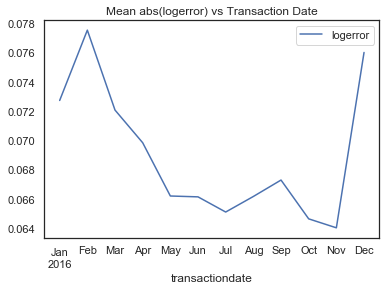

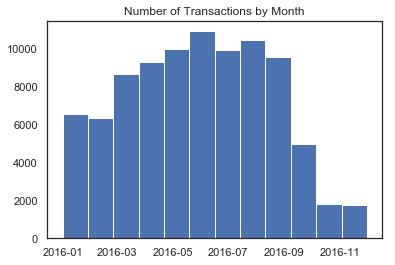

In [204]:
# plot logerrors over time
plt_df = combined_df[['transactiondate','logerror']].copy()
plt_df['transactiondate'] = plt_df.transactiondate.astype('datetime64[M]')
plt_df['logerror'] = np.abs(plt_df.logerror)
g = plt_df.groupby(['transactiondate']).mean()
g.plot()
plt.title("Mean abs(logerror) vs Transaction Date")
plt.show()
plt.hist(plt_df.transactiondate,bins=12)
plt.title("Number of Transactions by Month")
plt.show()

## <font color=red> This is the start of feature exploration, selection, and engineering... </font>

## Split dataset into train, dev, and test and filter to July 2016

In [205]:
# split the dataset into train (60%), dev (20%), and test (20%)
# Set a random seed (623) to keep our dataset consistent between runs
# Only use data from July 2016
df = shuffle(combined_df, random_state=623)

df = df[(df['transactiondate'] >= '2016-07-01') & (df['transactiondate'] <= '2016-07-31')]

train_data, train_labels = df.iloc[:int(len(df)*0.6), np.r_[0:54, 55:len(df.columns)]], df.iloc[:int(len(df)*0.6), 54:55].values
df_train = df.iloc[:int(len(df)*0.6), :]
dev_data, dev_labels = df.iloc[int(len(df)*0.6):int(len(df)*0.8), np.r_[0:54, 55:len(df.columns)]], df.iloc[int(len(df)*0.6):int(len(df)*0.8), 54:55].values
df_dev = df.iloc[int(len(df)*0.6):int(len(df)*0.8), :]
test_data, test_labels = df.iloc[int(len(df)*0.8):, np.r_[0:54, 55:len(df.columns)]], df.iloc[int(len(df)*0.8):, 54:55].values
df_test = df.iloc[int(len(df)/2):, :]
print(train_data.shape)


(5953, 59)


In [207]:
# confirm we got the right columns with our slicing
print(*train_data.columns,sep=" - ")

airconditioningtypeid - architecturalstyletypeid - basementsqft - bathroomcnt - bedroomcnt - buildingclasstypeid - buildingqualitytypeid - calculatedbathnbr - decktypeid - finishedfloor1squarefeet - calculatedfinishedsquarefeet - finishedsquarefeet12 - finishedsquarefeet13 - finishedsquarefeet15 - finishedsquarefeet50 - finishedsquarefeet6 - fireplacecnt - fullbathcnt - garagecarcnt - garagetotalsqft - hashottuborspa - heatingorsystemtypeid - latitude - longitude - lotsizesquarefeet - poolcnt - poolsizesum - pooltypeid10 - pooltypeid2 - pooltypeid7 - propertycountylandusecode - propertylandusetypeid - propertyzoningdesc - rawcensustractandblock - regionidcity - regionidcounty - regionidneighborhood - regionidzip - roomcnt - threequarterbathnbr - typeconstructiontypeid - unitcnt - yardbuildingsqft17 - yearbuilt - numberofstories - fireplaceflag - structuretaxvaluedollarcnt - taxvaluedollarcnt - assessmentyear - landtaxvaluedollarcnt - taxamount - taxdelinquencyflag - taxdelinquencyyear 

### Histograms of features in our train dataset

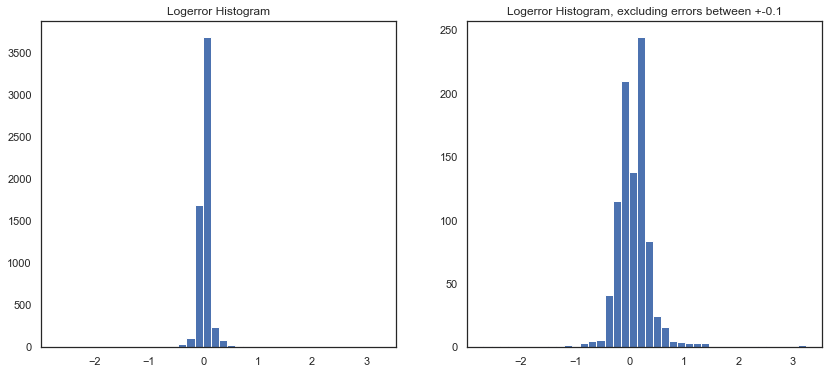

In [208]:
# plot histograms of Logerrors
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax.flatten()
ax[0].hist(df_train.logerror,bins=40)
ax[0].set_title("Logerror Histogram")
ax[1].hist(df_train.logerror[np.abs(df_train.logerror) >= 0.1],bins=40)
ax[1].set_title("Logerror Histogram, excluding errors between +-0.1")
plt.show()

C:\Users\amybr\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\amybr\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


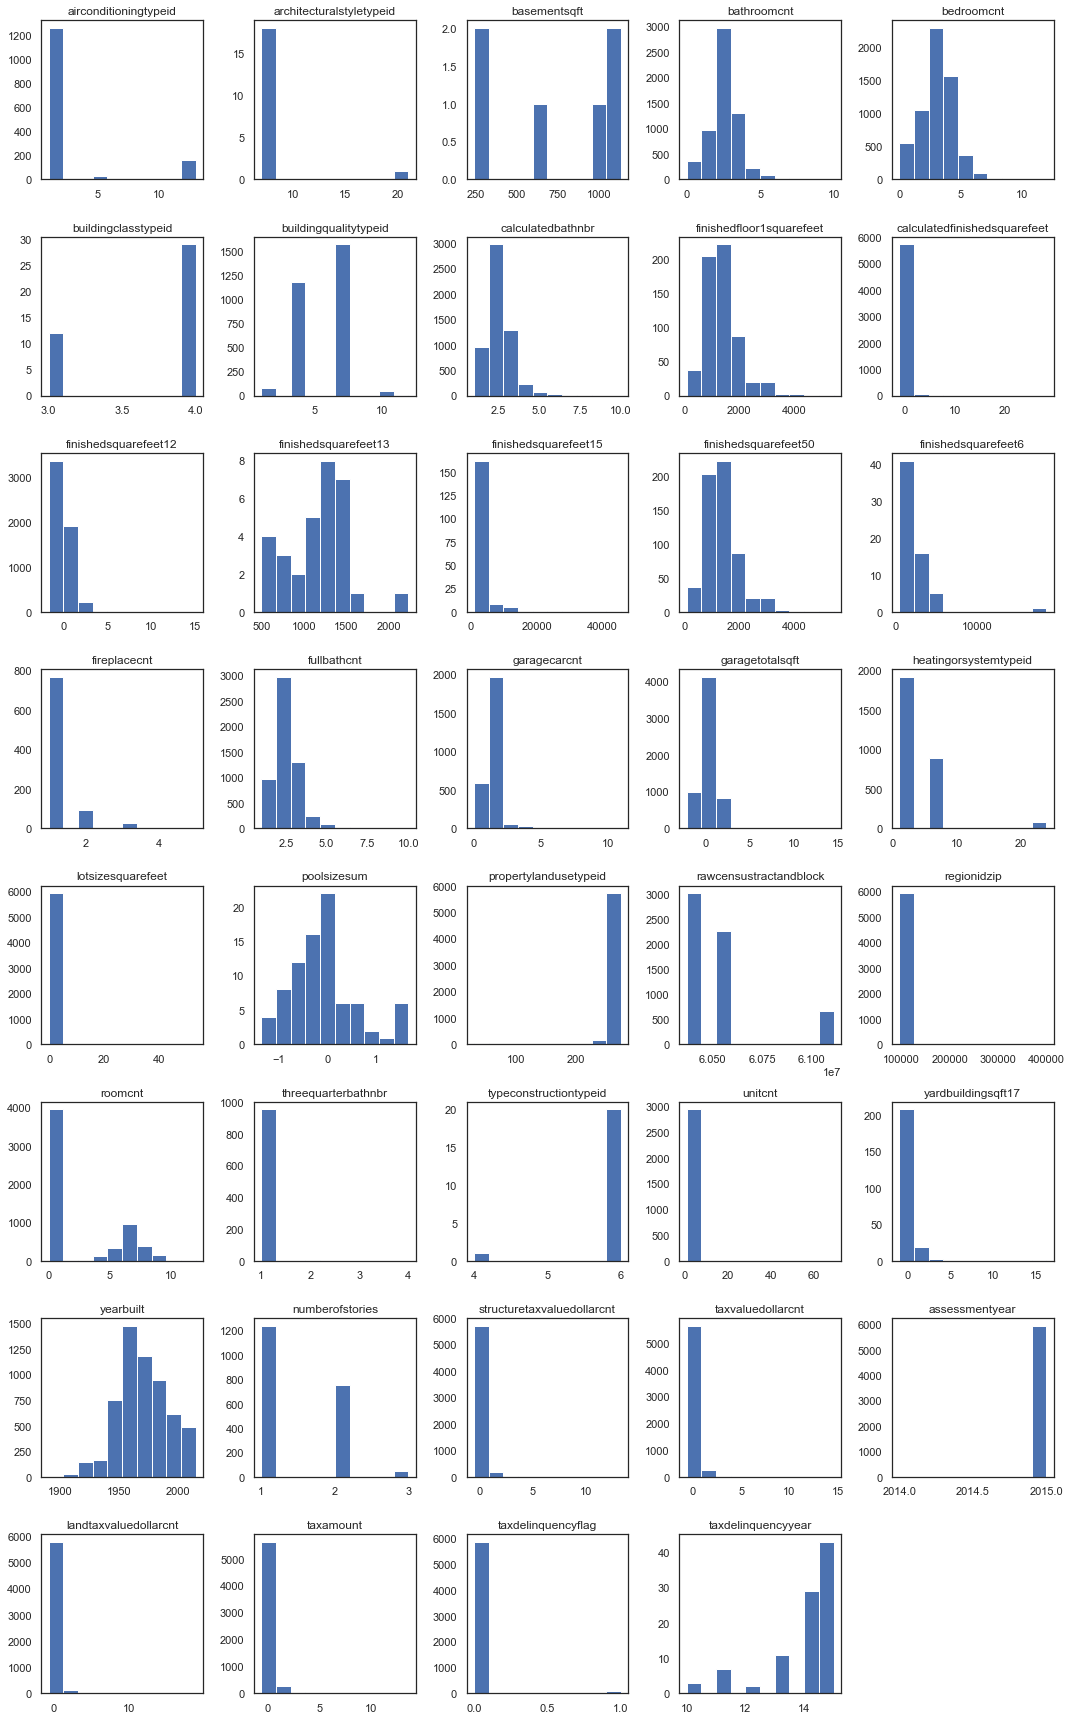

In [209]:
# Plot histograms of the columns of interest that aren't binomial or way too many categories
fig, ax = plt.subplots(8,5, figsize=(15,24))
ax = ax.flatten()
i = 0
for c in df_train.iloc[:,0:54].columns:
    if c in ['decktypeid','hashottuborspa','poolcnt','pooltypeid10','pooltypeid2','pooltypeid7','propertyzoningdesc',
             'propertycountylandusecode','regionidcity','regionidcounty','regionidneighborhood','fireplaceflag',
             'censustractandblock','latitude','longitude']:
        continue
    ax[i].hist(df_train[c])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(c)
    i+=1

plt.delaxes(ax[39])
plt.tight_layout()
plt.show()

## t-SNE Clustering
We perform t-SNE clustering to identify if there is a visible grouping of higher `logerror`s. While t-SNE is not great for hard analysis, it is a good visualization utility and would allow us to identify if there is a clear grouping of variables with larger logerrors

In [210]:
df_train.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'numberofstories', 'fireplaceflag'

In [211]:
# remove categorical variables for now
tsne_train_columns = ['basementsqft',
       'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'rawcensustractandblock','roomcnt',
       'threequarterbathnbr', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate']
tsne_train_df = df_train[tsne_train_columns].copy()

drop_columns = []
for column in tsne_train_df.columns:
    if (~tsne_train_df[column].isna()).sum() > 5000:
        continue
    
    drop_columns.append(column)
tsne_train_df.drop(drop_columns, axis='columns', inplace=True)
tsne_train_df['transactiondate'] = tsne_train_df['transactiondate'].astype(np.int64)

tsne_train_df['transactiondate'] = (tsne_train_df['transactiondate'] - tsne_train_df['transactiondate'].mean()) / tsne_train_df['transactiondate'].std()
tsne_train_df['assessmentyear'] = (tsne_train_df['assessmentyear'] - tsne_train_df['assessmentyear'].mean()) / tsne_train_df['assessmentyear'].std()
tsne_train_df.dropna(axis='rows', inplace=True)

tsna_train_np = tsne_train_df.loc[:,tsne_train_df.columns != 'logerror']
### WARNING!!! THIS TAKES A WHILE!!!
tsne_results = TSNE(n_components=2, verbose=1).fit_transform(tsna_train_np)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5408 samples in 0.016s...
[t-SNE] Computed neighbors for 5408 samples in 0.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5408
[t-SNE] Computed conditional probabilities for sample 2000 / 5408
[t-SNE] Computed conditional probabilities for sample 3000 / 5408
[t-SNE] Computed conditional probabilities for sample 4000 / 5408
[t-SNE] Computed conditional probabilities for sample 5000 / 5408
[t-SNE] Computed conditional probabilities for sample 5408 / 5408
[t-SNE] Mean sigma: 5.783055
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.505348
[t-SNE] KL divergence after 1000 iterations: 0.160915


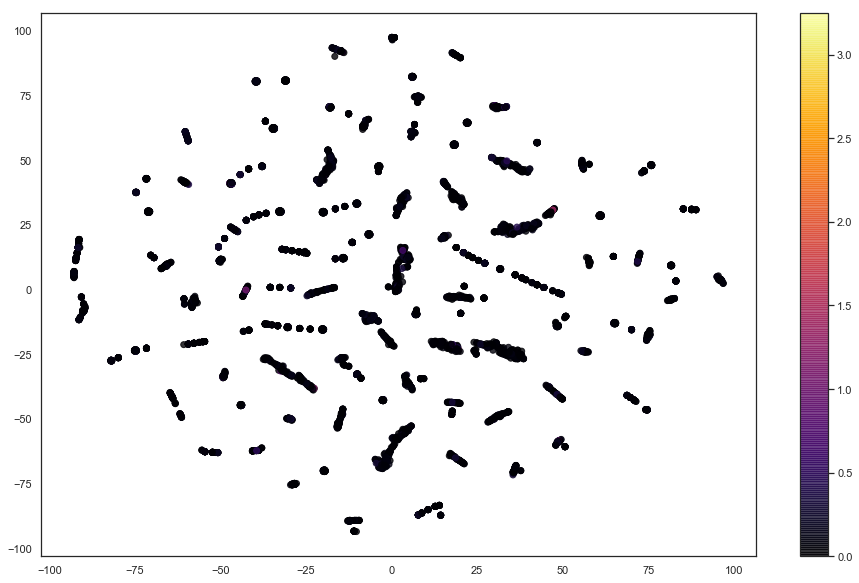

In [212]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha = .8, c = np.abs(tsne_train_df['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

As we saw in the earlier `logerror` distribution, a very large portion of the logerrors are extremely close to 0, making the colormapping difficult to understand. Let's observe the values both in and outside of these limits

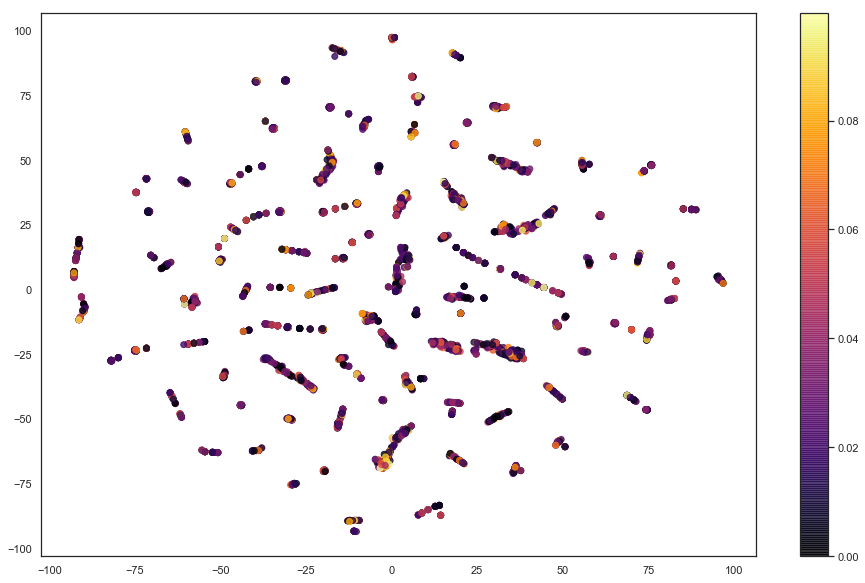

In [213]:
# filter out high logerrors
mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

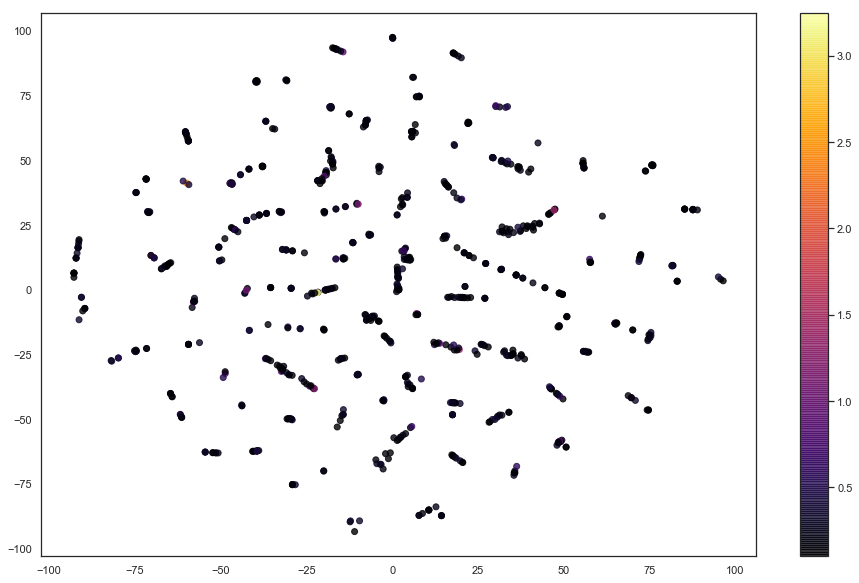

In [214]:
# filter out high logerrors
mask = np.abs(tsne_train_df['logerror']) > 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

Unfortunately it doesn't look like there is a very large tendency for clusters to have similar logerror values, which means that this task will be pretty difficult. One very interesting thing to note is the linearity in the clusters that were created. Typically these clusters are both long and fat, but in this distribution it appears to be very tight and skinny. I'm not sure what this indicates.